### Cálculo del NVDI para los proyectos visitados

### Cargue de las zonas de proyectos visitados y de un buffer de 10 KM para cada punto

In [27]:
import os
from dotenv import load_dotenv
import planet
from planet import Auth
import requests
import pandas as pd
import geopandas as gpd
from metodos_mixtos import mapas
import planet_functions as pf

import imageio
import rasterio
import numpy as np

In [11]:
#Cargar credenciales
load_dotenv()

PLANET_API_KEY = os.getenv("PLANET_API_KEY")
PLANET_USER=os.getenv("PLANET_USER")
PLANET_PASS=os.getenv("PLANET_PASS")

In [12]:
#Folder de datos
data_folder = '/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/geoinfo/Colombia/Bogotá/bosques_bogota'

In [13]:
#Crear el diccionario de rutas:
programacion_path = os.getenv("PROGRAMACION_PATH") 
geoinfo_path = os.getenv("GEOINFO_PATH")
rutas = mapas.diccionario_rutas(programacion_path, geoinfo_path)

### Cargar shapes relevantes

In [14]:
#Todos lso municipios de colombia
mpios = gpd.read_file(rutas['mpios'])

#Shape de Bogotá
bta = mpios[mpios['MPIO_CDPMP'] == '11001']

#Cargar el shape de macroterritorio rurales 
mtr_path = os.path.join(data_folder, 'macroterritorio_rural/Macroterritorio_Rural.shp')
mtr = gpd.read_file(mtr_path)

#Unidades de planeamiento local de Bogotá
upls_path = os.path.join(data_folder, 'unidadplaneamientolocal/UnidadPlaneamientoLocal.shp')
upls = gpd.read_file(upls_path)

#Solo las UPLs con clasificación rural o urbano-rural
upls_semi_rurales = upls[upls['VOCACION'].isin(['Urbano-Rural', 'Rural'])]

#Solo las UPLs clasificadas como rurales
upls_rurales = upls[upls['VOCACION'].isin(['Rural'])]

#Excluir las UPLs de Sumapáz y de Cuenta del Tunjuelo para mejor visualización
bta_compacta = upls[~upls['CODIGO_UPL'].isin(['UPL01','UPL02'])]


In [15]:
#Crear un área de interés
aoi = upls_rurales[upls_rurales['CODIGO_UPL'] == 'UPL06']

<Axes: >

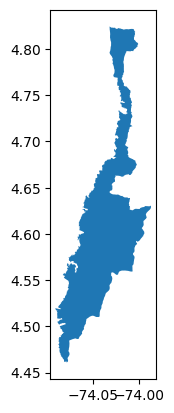

In [32]:
aoi.plot()

### Cálculo de NVDI
El cálculo del NVDI lo hacemos con base en este Tutorial de Planet:
- https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/?utm_source=google&utm_medium=paid-search&gad=1&gclid=CjwKCAjw6p-oBhAYEiwAgg2Pgnhzy0eAFD2MZSrSbYX7Q_i_ZDXBIL5AomP3D60wIud-_EHnZri4UxoCY80QAvD_BwE

In [16]:
#Autenticación
planet.Auth.from_login(PLANET_USER, PLANET_PASS)

In [17]:
API_KEY = PLANET_API_KEY

In [18]:
#setup session
session = requests.Session()

#authenticate
session.auth = (PLANET_API_KEY, "")

In [19]:
#Nombres de los mosaicos de Planet
mosaicos_path = os.path.join(data_folder, 'planet/planet_mosaics.xlsx')
#Import Excel with mosaic names
df2 = pd.read_excel(mosaicos_path)

### Descarga de las imágenes de Planet

In [20]:
#Parámetros
row = df2.loc[0]

In [21]:
asset_name = row['asset_name']
year = row['year']
month = row['month']
save_dir = os.path.join(data_folder, 'planet/imagenes_temporal/')
file_name = f'{year}_{month}'
crs = aoi.crs

In [22]:
#Esta función descarga el archivo tiff the planet
pf.download_planet_images(asset_name, 
                       aoi, 
                       save_dir, 
                       file_name, 
                       crs, 
                       session)

'/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/geoinfo/Colombia/Bogotá/bosques_bogota/planet/imagenes_temporal/2015_12/2015_12_2015-12_.tiff'

## Creación de imágenes visibles en png

In [23]:
def normalize_band(band, lower_percentile=2, upper_percentile=98):
    """
    Normalize a single band to a byte (0-255) scale using percentiles.
    """
    min_val = np.percentile(band, lower_percentile)
    max_val = np.percentile(band, upper_percentile)
    
    band_normalized = (band - min_val) / (max_val - min_val)
    band_normalized = np.clip(band_normalized, 0, 1)  # ensure all values are between 0 and 1
    return (band_normalized * 255).astype(np.uint8)


def tif_to_png(tif_path, png_path):
    """
    Converts a Planet .tif file to a visible PNG image.
    
    Parameters:
    - tif_path (str): Path to the input .tif file.
    - png_path (str): Path to save the output PNG image.
    """
    
    with rasterio.open(tif_path) as src:
        # Assuming the image is a standard 4-band PlanetScope image (BGRN)
        blue = normalize_band(src.read(1))
        green = normalize_band(src.read(2))
        red = normalize_band(src.read(3))
    
    # Stack RGB bands
    rgb = np.stack((red, green, blue), axis=-1)
    
    # Use imageio library to save the png
    import imageio
    imageio.imsave(png_path, rgb)
    
    #print(f"Saved visible PNG image to {png_path}")

In [28]:
#Convertir el .tiff en una imágen visible
tif_to_png('/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/geoinfo/Colombia/Bogotá/bosques_bogota/planet/imagenes_temporal/2015_12/2015_12_2015-12_.tiff', '/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/geoinfo/Colombia/Bogotá/bosques_bogota/planet/imagenes_temporal/2015_12/2015_12_2015-12_.png')

## Crop images 

In [136]:
def crop_rasters_to_gdf(gdf, raster_path_col, output_dir, cropped_raster_path):
    """
    Function to crop rasters based on bounding box of geometries in GeoDataFrame.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    def crop_raster(row):
        raster_path = row[raster_path_col]
        with rasterio.open(raster_path) as src:

            # Ensure that the raster and geometry have the same CRS
            geom = row['geometry']
            if gdf.crs != src.crs:
                geom = gpd.GeoSeries([geom], crs=gdf.crs).to_crs(src.crs).iloc[0]
            
            # Check for intersection between raster bounds and geometry bounds
            left, bottom, right, top = src.bounds
            raster_bbox = box(left, bottom, right, top)
            if not raster_bbox.intersects(geom):
                print(f"Warning: Geometry does not overlap with raster {raster_path}")
                return None
            
            # Crop the raster
            out_image, out_transform = mask(src, [geom], crop=True)
            out_meta = src.meta.copy()
            
            # Update metadata
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

            # Construct output raster path
            base_name = os.path.basename(raster_path)
            cropped_path = os.path.join(output_dir, f"cropped_{base_name}")
            
            # Write the cropped raster to disk
            with rasterio.open(cropped_path, "w", **out_meta) as dest:
                dest.write(out_image)
            
            return cropped_path

    # Apply the crop function to each row in the GeoDataFrame
    gdf[cropped_raster_path] = gdf.apply(crop_raster, axis=1)

    return gdf

In [140]:
gdf = crop_rasters_to_gdf(gdf, 'archivo_inicio', 'MMC - General - FIDA/ndvi/crooped', 'archivo_inicio_cropped')